In [3]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV

Uploading 'titanic.csv'

In [4]:
df = pd.read_csv('titanic.csv', index_col='PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Analyzing initial data

1. Зависимость выживания от параметров Sex, Pclass, Fare


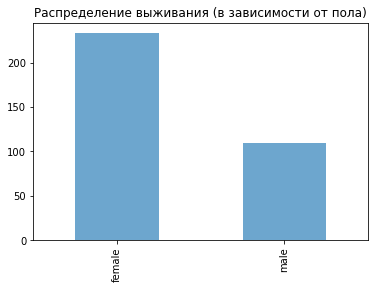

In [6]:
print('1. Dependency from parameters Sex, Pclass, Fare')
    
alpha_level = 0.65
    
# Sex
df_sex_survived = df.Sex[df.Survived == 1].value_counts()
df_sex_survived.plot(kind='bar', alpha=alpha_level)
plt.title("Распределение выживания (в зависимости от пола)")
plt.show()

In [7]:
data = df[df.Survived == 1]
n_data = data.groupby(['Sex']).agg({'Survived': 'count'})
new_data = n_data.groupby(level=0).apply(lambda x: round(100 * x / float(n_data['Survived'].sum()), 2))

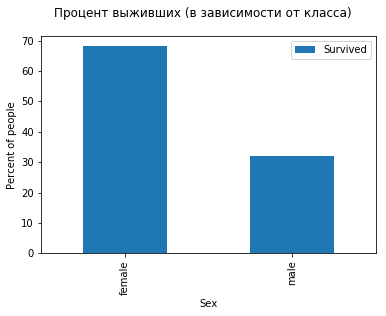

In [8]:
plt.figure()
figure = new_data.plot(kind='bar')
figure.set_ylabel('Percent of people')
figure.set_xlabel('Sex')
plt.suptitle('Процент выживших (в зависимости от класса)', fontsize = 12)
plt.show()

Мы видим, что для пассажира женского пола вероятность выжить была выше, чем у пассажира мужского пола. Значит признак пола значим для классификации.

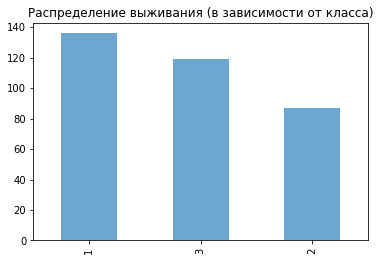

In [9]:
# Pclass
df_pclass_survived = df.Pclass[df.Survived == 1].value_counts()
df_pclass_survived.plot(kind='bar', alpha=alpha_level)
plt.title("Распределение выживания (в зависимости от класса)")
plt.show()

In [10]:
data = df[df.Survived == 1]
n_data = data.groupby(['Pclass']).agg({'Survived': 'count'})
new_data = n_data.groupby(level=0).apply(lambda x: round(100 * x / float(n_data['Survived'].sum()), 2))

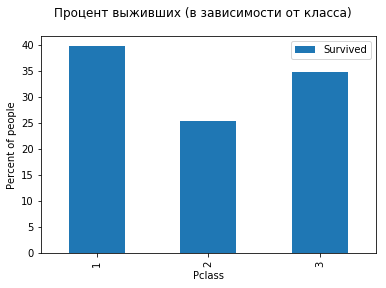

In [11]:
plt.figure()
figure = new_data.plot(kind='bar')
figure.set_ylabel('Percent of people')
figure.set_xlabel('Pclass')
plt.suptitle('Процент выживших (в зависимости от класса)', fontsize = 12)
plt.show()

Мы видим, что для пассажира первого класса вероятность выжить была выше, чем у пассажира второго класса и третьего классов. 
Для пассажира третьего класса вероятность выжить была выше, чем у пассажира второго класса. Заметим однако, что разница между вероятностями не настолько хорошо выражена, как у пола.

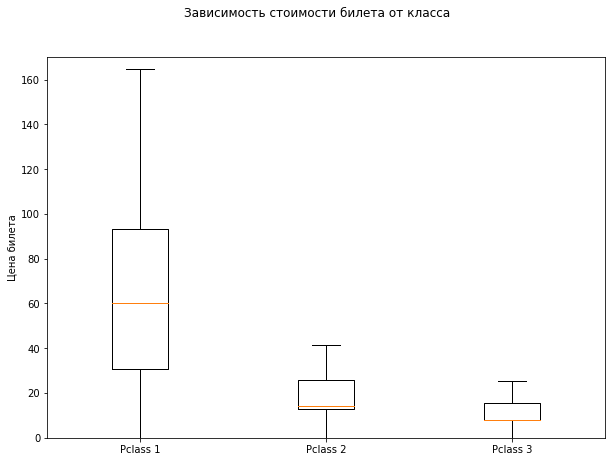

In [12]:
Pclass1 = df.Fare[df.Pclass == 1]
Pclass2 = df.Fare[df.Pclass == 2]
Pclass3 = df.Fare[df.Pclass == 3]

data_to_boxplot = [Pclass1, Pclass2, Pclass3]

plt.figure(1, figsize=(10, 7))
plt.boxplot([Pclass1, Pclass2, Pclass3], showfliers=False)  # убираем выбросы
plt.ylabel('Цена билета')
plt.xticks([1, 2, 3], ['Pclass 1', 'Pclass 2', 'Pclass 3'])
plt.suptitle('Зависимость стоимости билета от класса', fontsize = 12)
plt.ylim(0, 170)

plt.show()


Мы видим, что разброс в цене у пассажиров первого класса значительно больше, чем у пассажиров второго класса. Разброс в цене у пассажиров второго класса в смою очередь не намного больше разброса в цене у пассажиров третьего класса. В среднем пассажиры первого класса платили 60х, пассажиры второго класса - 20х, пассажиры третьего класса - 10х.

2. Гистограмма, описывающая среднюю вероятность выжить в зависимости от пола и соц. статуса


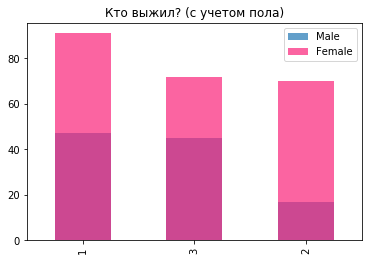

In [13]:
print('2. Гистограмма, описывающая среднюю вероятность выжить в зависимости от пола и соц. статуса')

df_male = df.Pclass[df.Sex == 'male'][df.Survived == 1].value_counts()       # выживших мужчин
df_female = df.Pclass[df.Sex == 'female'][df.Survived == 1].value_counts()   # выживших женщин

df_male.plot(kind='bar', label='Male', alpha=0.70)
df_female.plot(kind='bar', color='#FA2379', label='Female', alpha=0.70)
plt.title("Кто выжил? (с учетом пола)")
plt.legend(('Male', 'Female'), loc='best')
plt.show()

- У пассажира женского пола первого класса самая высокая вероятность выжить. 
- У женщин первого и второго класса вероятности выжить больше чем у мужчин их же класса. 
- У мужчин и женщин третьего класса примерно одинаковая вероятность выжить.

P(выжить|женщина, 1 класс) > P(выжить|мужчина, 1 класс)

P(выжить,женщина) > P(выжить, мужчина)

## Очистим данные и сформируем датасет

In [14]:
train = pd.read_csv('titanic.csv', index_col='PassengerId')
train.head(8)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [15]:
def missing(data):
    
    # Заменим пропуски в Age на медиану...
    median_age = data['Age'].median()
    data['Age'].fillna(value=median_age, inplace=True)
    
    # Заменим пропуски в Fare на медиану...
    median_fare = data['Fare'].median()
    data['Fare'].fillna(value=median_fare, inplace=True)

    # Заменим пропуски в Embarked
    mode_embarked = data['Embarked'].mode()[0]
    data['Embarked'].fillna(value=mode_embarked, inplace=True)
    
    # Создадим две новые категории. Можно предположить, что то, является ли человек одиночкой, 
    # и есть ли у него какие-то родственники может сыграть какую-нибудь роль
    data['Relatives'] = data["Parch"] + data["SibSp"]  # сколько всего родственников у человека
    data['Single'] = data["Relatives"].apply(lambda r: 1 if r == 0 else 0)   # является ли человек одиночкой
    
    # Дропнем ненужное
    data = data.drop(['Name','Cabin','Ticket'], 1) 

    data.head(8)
    return data

In [16]:
train = missing(train)
train.head(8)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Relatives,Single
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,1,0
2,1,1,female,38.0,1,0,71.2833,C,1,0
3,1,3,female,26.0,0,0,7.9250,S,0,1
4,1,1,female,35.0,1,0,53.1000,S,1,0
5,0,3,male,35.0,0,0,8.0500,S,0,1
6,0,3,male,28.0,0,0,8.4583,Q,0,1
7,0,1,male,54.0,0,0,51.8625,S,0,1
8,0,3,male,2.0,3,1,21.0750,S,4,0


In [17]:
# Переводим categorical в numerical
train = pd.get_dummies(train, drop_first=True)
train.head(8)

,Survived,Pclass,Age,SibSp,Parch,Fare,Relatives,Single,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,1,0,1
2,1,1,38.0,1,0,71.2833,1,0,0,0,0
3,1,3,26.0,0,0,7.9250,0,1,0,0,1
4,1,1,35.0,1,0,53.1000,1,0,0,0,1
5,0,3,35.0,0,0,8.0500,0,1,1,0,1
6,0,3,28.0,0,0,8.4583,0,1,1,1,0
7,0,1,54.0,0,0,51.8625,0,1,1,0,1
8,0,3,2.0,3,1,21.0750,4,0,1,0,1


In [18]:
x_labels = ['Pclass', 'Age', 'Fare', 'Single', 'Sex_male', 'Embarked_Q', 'Embarked_S'] 

In [19]:
X, y = train[x_labels], train['Survived']

## Analyzing parameters and choosing the best:

In [20]:
selector = SelectKBest(f_classif, k=5) # f_classif - дисперсионный анализ F-value между лейблом / функцией
selector.fit(X, y)

SelectKBest(k=5, score_func=<function f_classif at 0x00000289FAAEB1E0>)

In [21]:
scores = -np.log10(selector.pvalues_)  # p-values of feature scores

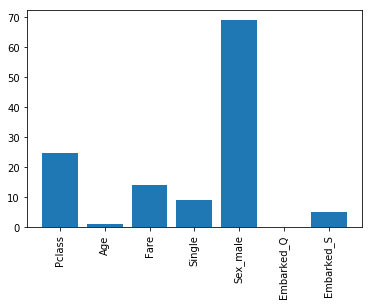

In [22]:
plt.bar(range(len(x_labels)), scores)
plt.xticks(range(len(x_labels)), x_labels, rotation='vertical')
plt.show()

Из графиков видно, что пол, класс играют важную роль в решении того, выживет ли человек. Можно также предположить,
что наличие семьи тоже играет положительную роль при принятии решении о том, кого посадить вместе

#### Looking at importances

In [23]:
dt_clf = DecisionTreeClassifier(random_state=42)

In [24]:
dt_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [25]:
importances = pd.Series(dt_clf.feature_importances_, index=x_labels)

In [26]:
importances

Pclass        0.123622
Age           0.231215
Fare          0.300038
Single        0.013962
Sex_male      0.310881
Embarked_Q    0.009156
Embarked_S    0.011126
dtype: float64

Мы видим, что большой вес имеет Sex_male, Age, Fare и Pclass. Самый маленький вес имеет Embarked_Q

In [27]:
rf_clf = RandomForestClassifier()

In [28]:
rf_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [29]:
importances = pd.Series(rf_clf.feature_importances_, index=x_labels)

In [30]:
importances

Pclass        0.084293
Age           0.281020
Fare          0.334506
Single        0.014238
Sex_male      0.260256
Embarked_Q    0.008171
Embarked_S    0.017516
dtype: float64

Мы видим, что большой вес имеет Sex_male, Age, Pclass и Fare. Самый маленький вес имеет Embarked_Q

## Divide on test and train groups and look at the parameters of models  DecisionTreeClassifier and RandomForest

In [31]:
# Удалим параметры, играющие небольшую роль
x_labels = ['Pclass', 'Age', 'Fare', 'Relatives', 'Sex_male', 'Embarked_S'] 
X, y = train[x_labels], train['Survived']

In [32]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

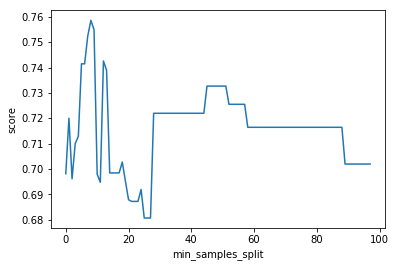

In [33]:
# Выборать наиболее удачный параметр и нарисовать в зависимости от этого дерево
scores = []
for t in range(2, 100):
    dt_clf = DecisionTreeClassifier(min_samples_split=t)
    dt_clf.fit(X_train, y_train)
    y_pred = dt_clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred))
    
plt.plot(scores)
plt.xlabel('min_samples_split')
plt.ylabel('score')
plt.show()

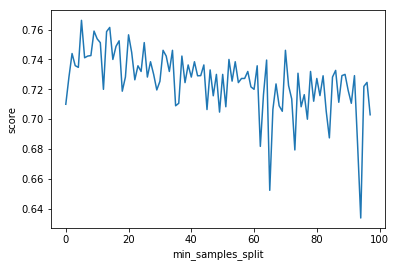

In [34]:
# Выборать наиболее удачный параметр и нарисовать в зависимости от этого дерево
scores = []
for t in range(2, 100):
    rf_clf = RandomForestClassifier(min_samples_split=t)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred))
    
plt.plot(scores)
plt.xlabel('min_samples_split')
plt.ylabel('score')
plt.show()

## Checking parameters with GridSearchCV and training DecisionTreeClassifier and RandomForest

In [41]:
def grid_search_function(clf, parameters, X_train, X_test, y_train, y_test):
    gs = GridSearchCV(clf, parameters)
    gs.fit(X_train, y_train)
    print (gs.best_params_)
    y_pred = gs.predict(X_test)
    print(classification_report(y_test, y_pred))
    return gs

In [42]:
dt_params = {
              'max_depth':[None, 3, 4, 5, 6, 10],
              'max_leaf_nodes':[None, 6, 8, 10, 12, 14],
              'min_samples_leaf': [3, 5, 7, 10]
             }

- max_depth - максимальная глубина дерева
- min_samples_leaf - наименьшее число примеров, достаточных для узла листа

In [43]:
dt_gs = grid_search_function(DecisionTreeClassifier(random_state=42), dt_params, X_train, X_test, y_train, y_test)

{'max_depth': None, 'max_leaf_nodes': 6, 'min_samples_leaf': 3}
             precision    recall  f1-score   support

          0       0.85      0.84      0.84       172
          1       0.72      0.74      0.73        96

avg / total       0.80      0.80      0.80       268



In [38]:
rf_params = {
              'n_estimators': [50, 65, 70, 75],
              'max_depth':[None, 6, 8, 10, 12],
              'max_leaf_nodes':[None, 6, 8, 10, 12],
              'min_samples_leaf': [2, 3, 4]
             }

- n_estimators - number of trees
- max_depth - max depth
- min_samples_leaf - min nimbers of trees (достаточных для узла листа)

In [39]:
rf_gs = grid_search_function(RandomForestClassifier(), rf_params, X_train, X_test, y_train, y_test)

{'max_depth': None, 'max_leaf_nodes': 8, 'min_samples_leaf': 3, 'n_estimators': 50}
             precision    recall  f1-score   support

          0       0.85      0.87      0.86       172
          1       0.76      0.73      0.74        96

avg / total       0.82      0.82      0.82       268



Мы видим, что DecisionTreeClassifier и RandomForestClassifier справляются с задачей классификации с примерно одинаковых успехом, оба достаточно хорошо. RandomForestClassifier справляется немного лучше

In [40]:
import graphviz
from sklearn import tree

clf_best = DecisionTreeClassifier(min_samples_split=dt_gs.best_estimator_.min_samples_split)

clf_best.fit(X_train, y_train)

tree.export_graphviz(clf_best, out_file='tree.dot', feature_names=x_labels)

with open("tree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)


ModuleNotFoundError: No module named 'graphviz'